<a href="https://colab.research.google.com/github/maawoo/nithecs_microschool_xarray_eo/blob/main/02_unlock_eo_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NITheCS micro school: 'Unlocking Earth Observation Data - Access and Analysis with Xarray Ecosystem Tools'

Date: March 28, 2025

Author: Marco Wolsza

Repository: https://github.com/maawoo/nithecs_microschool_xarray_eo

Recording: ...

Reach out to me on [Bluesky](https://bsky.app/profile/maawoo.bsky.social), [Mastodon](https://fosstodon.org/@maawoo)  or [LinkedIn](www.linkedin.com/in/maawoo)

Related NITheCS Micro-schools: [Introduction to Xarray](https://www.youtube.com/watch?v=SH7Xdmqz83c)

## 1 Introduction

[SpatioTemporal Asset Catalogs (STAC)](https://stacspec.org/en) is a family of metadata specifications that provides a "common language to describe geospatial information, so it can more easily be worked with, indexed, and discovered".

Platforms such as [Digital Earth Africa](https://www.digitalearthafrica.org) and [Planetary Computer](https://planetarycomputer.microsoft.com) provide access to a huge selection of Earth Observation (EO) and other spatiotemporal datasets to the public through STAC Catalogs.

Python packages such as [odc-stac](https://odc-stac.readthedocs.io/en/latest), [stackstac](https://stackstac.readthedocs.io/en/latest) and [cubo](https://cubo.readthedocs.io/en/latest) are able to turn STAC Items into on-demand data cubes, or to be more specific: multidimensional [Xarray](https://xarray.dev) objects.


The terms STAC **Catalog**, **Collection** and **Item** are going to appear throughout this notebook. You can think about these as:
* A bookshop = A **Catalog** hosted by a data provider. E.g., [Digital Earth Africa](https://explorer.digitalearth.africa/products)
* A book = A **Collection** is usually a specific data product. E.g., [s2_l2a](https://explorer.digitalearth.africa/products/s2_l2a) (Copernicus Sentinel-2)
* A chapter = Also a **Collection**. Data products are usually divided into smaller tiles in order to provide more efficient access. E.g., [34HBH](https://explorer.digitalearth.africa/product/s2_l2a/regions/34HBH)
* A page = An **Item** is a single entity of a data product. E.g., [S2B_34HBH_20250325_0_L2A](https://explorer.digitalearth.africa/products/s2_l2a/datasets/d688b68e-c191-5c8c-a288-439de9b82c7c)

In [ ]:
!pip install pystac_client odc-stac spyndex

In [2]:
import numpy as np
import xarray as xr
import pystac_client
from odc.stac import configure_rio, stac_load
import spyndex

## 2 From zero to data cube

### Step 0: Which data product do I want and how can I access it?

You can find a list of public STAC Catalogs [here](https://stacindex.org/catalogs?access=public).

My recommendations:

* [Digital Earth Africa](https://digitalearthafrica.org/)
  * [Product overview](https://docs.digitalearthafrica.org/en/latest/data_specs/index.html) & [Explorer](https://explorer.digitalearth.africa/products)
  * [Example usage notebooks](https://nbviewer.org/github/digitalearthafrica/deafrica-sandbox-notebooks/tree/main/)
  * [STAC access guide](https://docs.digitalearthafrica.org/en/latest/platform_tools/odc_stac.html)
  * STAC endpoint: `"https://explorer.digitalearth.africa/stac"`
* [Microsoft Planetary Computer](https://planetarycomputer.microsoft.com)
  * [Product overview](https://planetarycomputer.microsoft.com/catalog) & [Explorer](https://planetarycomputer.microsoft.com/explore)
  * Example usage notebooks included on each product page
  * [STAC access guide](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac)
  * STAC endpoint: `"https://planetarycomputer.microsoft.com/api/stac/v1"`

Let's define here the Catalog endpoint and the name of a Collection containing Copernicus Sentinel-1 RTC data that we're going to use in the following example:

In [3]:
dea_catalog_endpoint = "https://explorer.digitalearth.africa/stac"
dea_collection = ["s1_rtc"]

### Step 1: Define temporal and spatial dimensions

Before we start to load a geospatial dataset and create an on-demand data cube, we need to define two fundamental aspects:

**Temporal dimension**

Defining the time dimension is typically straightforward:
* You can define a date range as start and end timestamps
* Most libraries accept a standard datetime string format called ISO 8601 (e.g., `'2023-01-15'`)

In [4]:
date_range = ("2021-01-01", "2021-12-31")

# Example of using a simplified string to query a specific year-month or year:
#date_range = "2021-06"
#date_range = "2021"

# Example for an open-ended query:
#date_range = ("2021-01-01", None)

**Spatial dimension**

To define the spatial dimension, several approaches are possible:
* You know your area of interest so well that you can just type down its coordinates by heart.
* Your area of interest is already stored as a geospatial vector file like GeoJSON or GeoPackage, which you can load using packages such as [GeoPandas](https://geopandas.org/en/stable).
* You use an interactive map to define your area of interest.
    * Using [geojson.io](https://geojson.io/), for example, you can export the result as a vector file and load that into Python as described before.
    * Or you could create a simple, interactive map directly in Python using [ipyleaflet](https://ipyleaflet.readthedocs.io/en/latest)...

In [17]:
from ipyleaflet import Map, DrawControl

def handle_draw(target, action, geo_json):
  if action == 'created':
    if geo_json['geometry']['type'] == 'Point':
        lon, lat = geo_json['geometry']['coordinates']
        print(f"Marker Coordinates (lon, lat): {lon}, {lat}")
    elif geo_json['geometry']['type'] == 'Polygon':
        coords = geo_json['geometry']['coordinates'][0]
        min_lon, max_lon = min(coord[0] for coord in coords), max(coord[0] for coord in coords)
        min_lat, max_lat = min(coord[1] for coord in coords), max(coord[1] for coord in coords)
        print(f"Bounding Box coordinates (min_lon, min_lat, max_lon, max_lat): {min_lon}, {min_lat}, {max_lon}, {max_lat}")

dc = DrawControl(
    marker={"shapeOptions": {"color": "#0000FF"}},
    rectangle={"shapeOptions": {"color": "#0000FF"}},
    polygon={}, polyline={}, circle={}, circlemarker={}
)

dc.on_draw(handle_draw)
m = Map(center=[-34.08, 21.87], zoom=8)
m.add(dc)
m

Map(center=[-34.08, 21.87], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_…

If you're interested in doing basic geospatial analysis using interactive mapping in Python, have a look at [leafmap](https://leafmap.org)!

In [5]:
bbox = [18.78, -34.014, 18.97, -33.87]

### Step 2: Query a STAC Catalog

We can use the package [pystac_client](https://pystac-client.readthedocs.io/en/stable) to query STAC Catalogs by "opening" it first and then performing a search:

In [6]:
dea_catalog = pystac_client.Client.open(dea_catalog_endpoint)

In [7]:
query = dea_catalog.search(
    collections=dea_collection,
    datetime=date_range,
    bbox=bbox,
)

dea_items = list(query.items())
print(f"Found: {len(dea_items)} Items")

Found: 122 Items


### Step 3: Load data into Xarray object

Now that we have a list of STAC Items, there are several options on how we can load these into Xarray. We will focus here on the package `odc-stac`. More detailed example notebooks can be found [here](https://docs.digitalearthafrica.org/en/latest/platform_tools/odc_stac.html) and [here](https://odc-stac.readthedocs.io/en/latest/examples.html). Examples for other common options are provided in the bonus section.

The following configuration is specific to loading Digital Earth Africa data, which is hosted on AWS:

In [8]:
configure_rio(
    cloud_defaults=True,
    aws={"aws_unsigned": True},
    AWS_S3_ENDPOINT="s3.af-south-1.amazonaws.com",
)

Using the [`stac_load`](https://odc-stac.readthedocs.io/en/latest/_api/odc.stac.load.html#odc.stac.load)-function from `odc-stac`, we can now load our STAC Items into Xarray:

In [9]:
s1 = stac_load(
    dea_items,
    bbox=bbox,
    bands=('vh', 'vv'),
    dtype='float32',
    chunks={'x': 'auto', 'y': 'auto', 'time': 1},
    groupby='solar_day',
)

s1

<xarray.Dataset> Size: 334MB
Dimensions:      (latitude: 720, longitude: 950, time: 61)
Coordinates:
  * latitude     (latitude) float64 6kB -33.87 -33.87 -33.87 ... -34.01 -34.01
  * longitude    (longitude) float64 8kB 18.78 18.78 18.78 ... 18.97 18.97 18.97
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 488B 2021-01-03T17:33:58.989618 ... 20...
Data variables:
    vh           (time, latitude, longitude) float32 167MB dask.array<chunksize=(1, 720, 950), meta=np.ndarray>
    vv           (time, latitude, longitude) float32 167MB dask.array<chunksize=(1, 720, 950), meta=np.ndarray>

* You can **get information** about available bands, their names and data types **from the respective data product page**. E.g., [here](https://explorer.digitalearth.africa/products/s1_rtc#measurements) for the `s1_rtc` product.
* Other parameters are available that could potentially load the dataset in a completely different way than how it is actually stored (e.g., changing coordinate reference system, resampling and resolution). Best to **use parameters that align with how the data is stored**, especially if you're not sure about what you're doing.
* **Using the `chunks`-parameter can be quite important**. By using it, the data will be loaded as _lazy_ [dask](https://www.dask.org)-backed Xarray objects. This avoids loading datasets that are larger than available memory and executes computations not immediately, but after being requested (e.g., plotting, writing on disk or by using a `.compute()` command)
  * You can find more information about this topic [here](https://docs.xarray.dev/en/stable/user-guide/dask.html) in the Xarray documentation and in [this tutorial](https://foundations.projectpythia.org/core/xarray/dask-arrays-xarray.html).

Let's demonstrate this lazy execution with a practical example:

In [10]:
s1_scene_vh_db = 10*np.log10(s1.vh.sel(time="2021-06").mean(dim='time'))
s1_scene_vh_db

<xarray.DataArray 'vh' (latitude: 720, longitude: 950)> Size: 3MB
dask.array<mul, shape=(720, 950), dtype=float32, chunksize=(720, 950), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float64 6kB -33.87 -33.87 -33.87 ... -34.01 -34.01
  * longitude    (longitude) float64 8kB 18.78 18.78 18.78 ... 18.97 18.97 18.97
    spatial_ref  int32 4B 4326

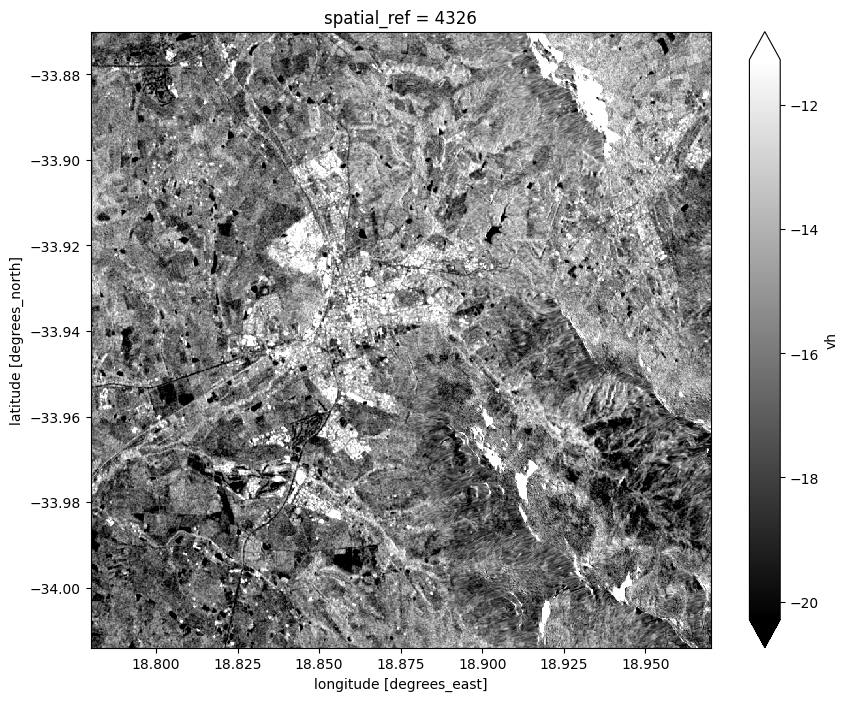

In [22]:
s1_scene_vh_db.plot(cmap='gray', figsize=(10, 8), robust=True)

The `robust=True` parameter will remove outliers before plotting by using the 2nd and 98th percentiles of the data. See [here](https://docs.xarray.dev/en/stable/user-guide/plotting.html#robust-plotting) for more information.

### Summary

In [ ]:
# Configure AWS endpoint (specific to loading Digital Earth Africa data)
configure_rio(
    cloud_defaults=True,
    aws={"aws_unsigned": True},
    AWS_S3_ENDPOINT="s3.af-south-1.amazonaws.com",
)

# Open Catalog, run search query and retrieve Items
dea_catalog = pystac_client.Client.open(dea_catalog_endpoint)
query = dea_catalog.search(
    collections=dea_collection,
    datetime=date_range,
    bbox=bbox,
)
dea_items = list(query.items())

# Check data product for relevant information and load into Xarray
s1 = stac_load(
    dea_items,
    bbox=bbox,
    bands=('vh', 'vv'),
    dtype='float32',
    chunks={'x': 'auto', 'y': 'auto', 'time': -1},
    groupby='solar_day',
)

### Bonus: cubo and GEE

Due to a current dependency [issue](https://github.com/ESDS-Leipzig/cubo/pull/17), we will install a fork of `cubo`. Once this is resolved, the installation can be simplified.

In [23]:
!pip install git+https://github.com/maawoo/cubo.git earthengine-api xee
#!pip install cubo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 kB 2.9 MB/s eta 0:00:00
  Cloning https://github.com/maawoo/cubo.git to /tmp/pip-req-build-yya4suxc
  Running command git clone --filter=blob:none --quiet https://github.com/maawoo/cubo.git /tmp/pip-req-build-yya4suxc
  Resolved https://github.com/maawoo/cubo.git to commit 31be3b3b202e7db4ac3aad6cd5bc748a5aa37778
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.4 MB/s eta 0:00:00
  Created wheel for cubo: filename=cubo-2024.8.0-py3-none-any.whl size=10160 sha256=a039f5febdcb09c935812eac27a83532d976a8cbd26ed2e661802e03479c509f
  Stored in directory: /tmp/pip-ephem-wheel-cache-li_kcwz4/wheels/95/a1/95/f31e31aed95b11181c6c2f2bdd2c9818fcf9ceb1a369c1efcd
Successfully built cubo


In [24]:
import cubo

The `cubo` package is following a different approach of loading geospatial data into Xarray. It is working best when loading from [Microsoft Planetary Computer](https://planetarycomputer.microsoft.com/) or from [Google Earth Engine](https://developers.google.com/earth-engine/datasets) by making use of the [`Xee`](https://xee.readthedocs.io/en/latest/)-package.

In comparison to the `odc-stac` example above, we don't need to search for STAC Items ourselves. Another significant difference is the way the spatial dimension is defined. Instead of defining a bounding box, we just pass a single coordinate together with the desired edge size and resolution of the date cube. See the documentation of [`cubo`](https://cubo.readthedocs.io/en/latest/index.html) and specifically the [`cubo.create`](https://cubo.readthedocs.io/en/latest/stubs/cubo.cubo.create.html#cubo.cubo.create)-function for more information.


In [58]:
s2_pc = cubo.create(
    stac="https://planetarycomputer.microsoft.com/api/stac/v1", # STAC endpoint to access
    collection="sentinel-2-l2a", # Name of the STAC collection
    bands=["B02","B03","B04", "B08"], # Bands to retrieve
    start_date="2021-01-01", # Start date of the cube
    end_date="2021-12-31", # End date of the cube
    lat=-34.825, # Central latitude of the cube
    lon=20.032, # Central longitude of the cube
    edge_size=1000, # Edge size of the cube (px)
    resolution=10,
    stackstac_kw=dict( # stackstac keyword arguments
        chunksize={'time': -1},
    )
)

s2_pc

<xarray.DataArray 'sentinel-2-l2a' (time: 276, band: 4, y: 1000, x: 1000)> Size: 9GB
dask.array<fetch_raster_window, shape=(276, 4, 1000, 1000), dtype=float64, chunksize=(276, 4, 1000, 1000), chunktype=numpy.ndarray>
Coordinates: (12/45)
  * time                                     (time) datetime64[ns] 2kB 2021-0...
    id                                       (time) <U54 60kB 'S2B_MSIL2A_202...
  * band                                     (band) <U3 48B 'B02' ... 'B08'
  * x                                        (x) float64 8kB 4.065e+05 ... 4....
  * y                                        (y) float64 8kB 6.151e+06 ... 6....
    s2:not_vegetated_percentage              (time) float64 2kB 14.92 ... 10.69
    ...                                       ...
    title                                    (band) <U20 320B 'Band 2 - Blue ...
    common_name                              (band) <U5 80B 'blue' ... 'nir'
    center_wavelength                        (band) float64 32B 0.49 ... 0.842
    full_width_half_max                      (band) float64 32B 0.098 ... 0.145
    epsg                                     int64 8B 32734
    cubo:distance_from_center                (y, x) float64 8MB 7.073e+03 ......
Attributes:
    collection:           sentinel-2-l2a
    stac:                 https://planetarycomputer.microsoft.com/api/stac/v1
    epsg:                 32734
    resolution:           10
    edge_size:            1000
    edge_size_m:          10000
    central_lat:          -34.825
    central_lon:          20.032
    central_y:            6145936.436002662
    central_x:            411479.27352154383
    time_coverage_start:  2021-01-01
    time_coverage_end:    2021-12-31

The chunking and thus lazy loading of the data is done automatically. The `cubo.create`-function itself doesn't have a related parameter. If you want to make adjustments, you need to pass keyword arguments to the [`stackstac`](https://stackstac.readthedocs.io/en/latest/) package and its [`stackstac.stack`](https://stackstac.readthedocs.io/en/latest/api/main/stackstac.stack.html#stackstac.stack)-function in particular. This is used by `cubo` to load Items into Xarray objects.

As you might have noticed, the loaded Xarray object seems to be constructed somewhat differently to what we have seen earlier when loading data using `odc-stac`. If you're interested in learning more about the differences see these discussions: [here](https://github.com/opendatacube/odc-stac/issues/54) and [here](https://discourse.pangeo.io/t/comparing-odc-stac-load-and-stackstac-for-raster-composite-workflow/4097). Both approaches have advantages and disadvantages. Personally, I have initially started with `stackstac` and moved over to using `odc-stac` at some point.

Well, enough talking... here is a nice image:

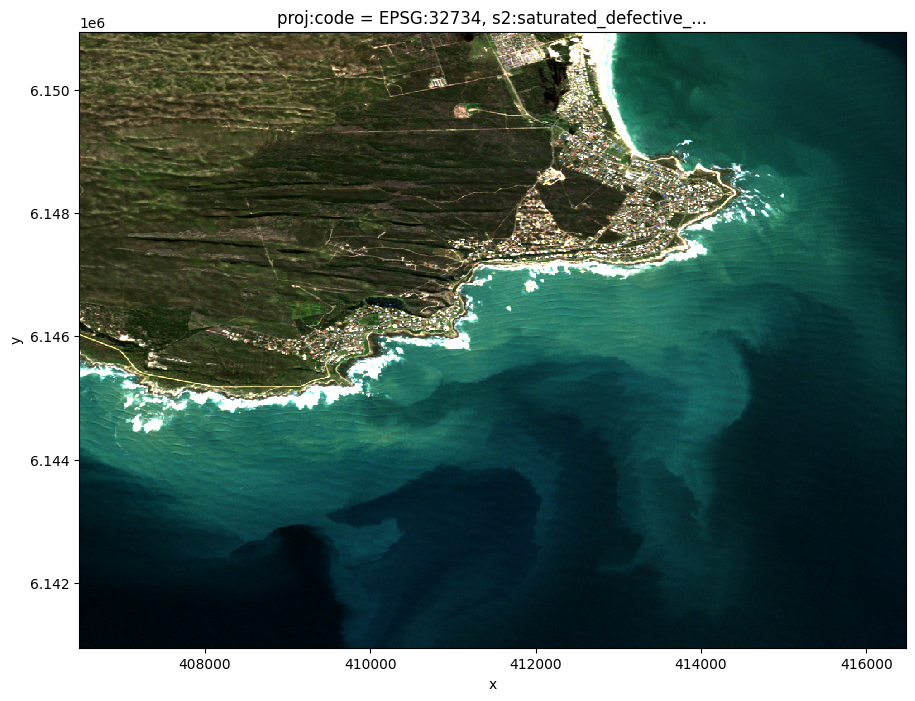

In [44]:
s2_pc.sel(band=['B04', 'B03', 'B02'], time="2021-06-06").mean(dim='time').plot.imshow(rgb="band", robust=True, size=8)

In order to access the Google Earth Engine Catalog using `cubo`, some extra authentification steps are necessary:

In [45]:
!earthengine authenticate --quiet

E0000 00:00:1743152581.195231   22158 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743152581.290410   22158 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Authenticate: Limited support in Colab. Use ee.Authenticate() or --auth_mode=notebook instead.
W0328 09:03:08.178327 20404902916096 _default.py:711] No project ID could be determined. Consider running `gcloud config set project` or setting the GOOGLE_CLOUD_PROJECT environment variable
Paste the following address into a web browser:

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/cloud-platform%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=5apD_ONNHYLSRgJ544LuEglSE7jZ2FEJYSbn6OZrWs8&tc=w-t25p2KNddRzRlTOEBYm_NxHMYxIsBqJlxllB

In [46]:
import ee

ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')

In [48]:
s2_gee = cubo.create(
   gee=True, # Use GEE instead of STAC
   collection="COPERNICUS/S2_SR_HARMONIZED", # Id of the GEE collection
   bands=["B2","B3","B4"], # Bands to retrieve (note that these have slightly different names!)
   start_date="2021-01-01", # Start date of the cube
   end_date="2021-12-31", # End date of the cube
   lat=-34.825, # Central latitude of the cube
   lon=20.032, # Central longitude of the cube
   edge_size=1000, # Edge size of the cube (px)
   resolution=10, # Pixel size of the cube (m)
)

s2_gee

<xarray.DataArray 'COPERNICUS/S2_SR_HARMONIZED' (time: 296, band: 3, y: 1000,
                                                 x: 1000)> Size: 4GB
dask.array<transpose, shape=(296, 3, 1000, 1000), dtype=float32, chunksize=(48, 1, 256, 512), chunktype=numpy.ndarray>
Coordinates:
  * time                       (time) datetime64[ns] 2kB 2021-01-02T08:40:09....
  * x                          (x) float64 8kB 4.065e+05 4.065e+05 ... 4.165e+05
  * y                          (y) float64 8kB 6.141e+06 6.141e+06 ... 6.151e+06
  * band                       (band) object 24B 'B2' 'B3' 'B4'
    cubo:distance_from_center  (y, x) float64 8MB 7.061e+03 ... 7.067e+03
Attributes:
    collection:           COPERNICUS/S2_SR_HARMONIZED
    stac:                 https://earthengine-stac.storage.googleapis.com/cat...
    epsg:                 32734
    resolution:           10
    edge_size:            1000
    edge_size_m:          10000
    central_lat:          -34.825
    central_lon:          20.032
    central_y:            6145936.436002662
    central_x:            411479.27352154383
    time_coverage_start:  2021-01-01
    time_coverage_end:    2021-12-31

As you can see, we load almost the same data as from Planetary Computer. Almost, because if you look closely you will notice that more time steps were loaded this time. This is likely due to a different tiling scheme used by both platforms.

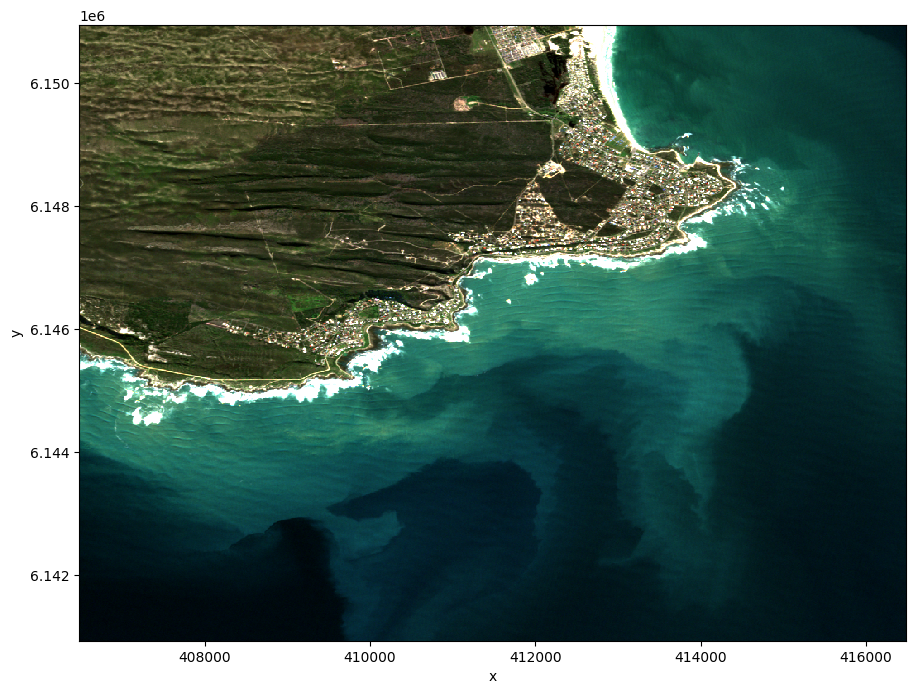

In [50]:
s2_gee.sel(band=['B4', 'B3', 'B2'], time="2021-06-06").mean(dim='time').plot.imshow(rgb="band", robust=True, size=8)

## 3 Analysis examples

### 1 Use spyndex to calculate indices

For more information have a look at the [spyndex documentation](https://spyndex.readthedocs.io/en/latest/) and [this notebook](https://jena-earth-observation-school.github.io/sdc-tools/content/03/04_00_Spyndex.html#), which is a more detailed version of what I'm showing in the following cells.

In [12]:
query = dea_catalog.search(
    collections=['s2_l2a'],
    datetime=date_range,
    bbox=bbox,
)
dea_items = list(query.items())

s2 = stac_load(
    dea_items,
    bbox=bbox,
    bands=('B02', 'B03', 'B04', 'B08'),
    dtype='uint16',
    chunks={'x': 'auto', 'y': 'auto', 'time': -1},
    groupby='solar_day',
)

In [13]:
spyndex.indices.EVI

SpectralIndex(EVI: Enhanced Vegetation Index)
        * Application Domain: vegetation
        * Bands/Parameters: ['g', 'N', 'R', 'C1', 'C2', 'B', 'L']
        * Formula: g*(N-R)/(N+C1*R-C2*B+L)
        * Reference: https://doi.org/10.1016/S0034-4257(96)00112-5
        

In [14]:
params = {'N': s2.B08/10000,
          'R': s2.B04/10000,
          'B': s2.B02/10000,
          'g': 2.5,
          'C1': 6.0,
          'C2': 7.5,
          'L': 1.0}

s2_indices = spyndex.computeIndex(index=['NDVI', 'EVI'],
                                  params=params)
s2_indices

<xarray.DataArray (index: 2, time: 73, y: 1635, x: 1790)> Size: 3GB
dask.array<concatenate, shape=(2, 73, 1635, 1790), dtype=float64, chunksize=(1, 73, 958, 958), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 13kB 6.25e+06 6.25e+06 6.25e+06 ... 6.234e+06 6.234e+06
  * x        (x) float64 14kB 2.947e+05 2.947e+05 ... 3.125e+05 3.125e+05
  * time     (time) datetime64[ns] 584B 2021-01-05T08:49:49 ... 2021-12-31T08...
  * index    (index) <U4 32B 'NDVI' 'EVI'

In [15]:
evi = s2_indices.sel(index='EVI')
ndvi = s2_indices.sel(index='NDVI')
ndvi

<xarray.DataArray (time: 73, y: 1635, x: 1790)> Size: 2GB
dask.array<getitem, shape=(73, 1635, 1790), dtype=float64, chunksize=(73, 958, 958), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 13kB 6.25e+06 6.25e+06 6.25e+06 ... 6.234e+06 6.234e+06
  * x        (x) float64 14kB 2.947e+05 2.947e+05 ... 3.125e+05 3.125e+05
  * time     (time) datetime64[ns] 584B 2021-01-05T08:49:49 ... 2021-12-31T08...
    index    <U4 16B 'NDVI'

In [ ]:
import matplotlib.pyplot as plt

pt = (18.876572, -33.933248)
ndvi_pt = ndvi.sel(x=pt[0], y=pt[1], method="nearest")
evi_pt = evi.sel(x=pt[0], y=pt[1], method="nearest")

ndvi_pt.plot.scatter(x="time", label="NDVI")
evi_pt.plot.scatter(x="time", label="EVI")
plt.title(f"Comparison of NDVI and EVI time series; lat: {pt[1]}, lon: {pt[0]}")
plt.ylabel("Index")
plt.legend()

### 2 Create a simple landcover mask

## 4 Next steps

* If you want to get started analysing EO data for a specific application (e.g., agriculture monitoring) and learn from practical examples: [Digital Earth Africa Notebooks](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks)
* If you want to learn about EO fundamentals: [EO College](https://eo-college.org)